# Set up High-level model

This is what the model should do:

<details> 
  <summary> Image of HL model graph </summary>
  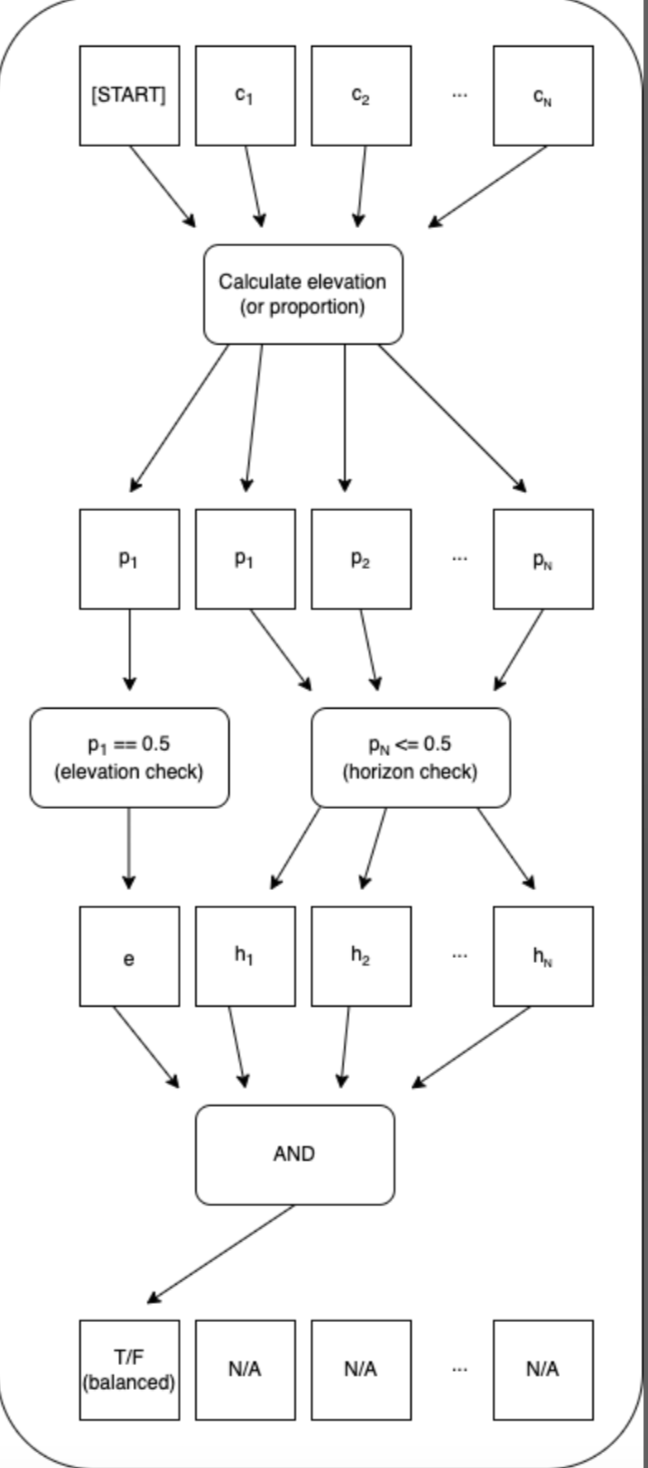
</details>

In [1]:
from jaxtyping import Float, Int, Bool
import torch as t
from transformer_lens.hook_points import HookedRootModule, HookPoint

In [2]:
class ElevationHead(t.nn.Module):
    """ Calculates the elevation at each position in the context"""
    
    def forward(self, tokens: Int[t.Tensor, "batch seq"]) -> Int[t.Tensor, "batch seq"]:
        """ Vocabulary:
                0 - [START]
                1 - (
                2 - )
                3 - [PAD]
        """
        #tok_clone is 1 for ( and -1 for )
        tok_clone = tokens.clone()
        tok_clone[tok_clone == 3] = 0
        tok_clone[tok_clone == 2] = -1

        #we'll count left to right.
        elevation = t.cumsum(tok_clone, dim=1).to(int)

        return elevation
        
#quick check.
tokens = [[0, 1, 2, 1, 2, 1, 2, 3, 3, 3, 3],
          [0, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3],
          [0, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1],
          [0, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2]
         ]
head = ElevationHead()
elevations = head(t.Tensor(tokens))   
elevations

tensor([[ 0,  1,  0,  1,  0,  1,  0,  0,  0,  0,  0],
        [ 0,  1,  2,  3,  4,  5,  4,  3,  2,  2,  2],
        [ 0, -1,  0, -1,  0, -1,  0, -1,  0, -1,  0],
        [ 0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0]])

In [3]:
class CheckElevation(t.nn.Module):
    """ Checks if the elevation in token position -1 is 0.
        Returns 1 if so and 0 if false.
    """

    def forward(self, elevations: Int[t.Tensor, "batch seq"]) -> Bool[t.Tensor, "batch seq"]:
        elevation_bool = t.ones(elevations.shape, dtype=t.bool)
        elevation_bool[elevations[:,-1].nonzero(), -1] = 0
        return elevation_bool

class CheckHorizon(t.nn.Module):
    """ Checks if the horizon is ever violated (elevation drops below 0)
    """

    def forward(self, elevations: Int[t.Tensor, "batch seq"]) -> Bool[t.Tensor, "batch seq"]:
        horizon_bool = t.ones(elevations.shape, dtype=t.bool)
        horizon_bool[elevations < 0] = 0
        return horizon_bool

check_ele = CheckElevation()
check_hor = CheckHorizon()
ele_check = check_ele(elevations)
hor_check = check_hor(elevations)
print(ele_check)
print(hor_check)

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True]])
tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True, False,  True, False,  True, False,  True, False,  True, False,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True]])


In [4]:
class BalanceCheckHead(t.nn.Module):
    """ Checks to see if the balance has been violated previously in the sequence. """
    def forward(
        self, 
        horizon_check: Bool[t.Tensor, "batch seq"], 
        elevation_check: Bool[t.Tensor, "batch seq"]
    ) -> Bool[t.Tensor, "batch seq"]:
        both_checks = horizon_check*elevation_check
        return t.cumprod(both_checks, dim=1).bool()

bchead = BalanceCheckHead()
bchead(hor_check, ele_check)

tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False],
        [ True, False, False, False, False, False, False, False, False, False,
         False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True]])

In [5]:
class HighLevelParensBalanceChecker(HookedRootModule):
    """
    Components:
    - Elevation Calculation Head
    - Elevation Check method
    - Horizon Check method
    - Balance Check Head
    """
    def __init__(self):
        super().__init__()
        self.input_hook = HookPoint()
        self.elevation_head = ElevationHead()
        self.elevation_hook = HookPoint()
        self.elevation_checker = CheckElevation()
        self.elevation_check_hook = HookPoint()
        self.horizon_checker = CheckHorizon()
        self.horizon_check_hook = HookPoint()
        self.balance_check_head = BalanceCheckHead()
        self.balance_check_hook = HookPoint()
        self.setup()

    def forward(self, tokens: Int[t.Tensor, "batch seq"]) -> Float[t.Tensor, "batch seq"]:
        tokens = self.input_hook(tokens)
        elevation = self.elevation_hook(self.elevation_head(tokens))
        ele_check = self.elevation_check_hook(self.elevation_checker(elevation))
        hor_check = self.horizon_check_hook(self.horizon_checker(elevation))
        balance = self.balance_check_hook(self.balance_check_head(hor_check, ele_check))
        return balance.float().cuda()

    def is_categorical(self):
        return False

    # def run_with_cache(self, input: tuple):
    #     """ work with iit's dumb reimplementation here """
    #     return super().run_with_cache(input[0])

    # def run_with_hooks(self, input: tuple, *args, **kwargs):
    #     """ work with iit's dumb reimplementation here """
    #     return super().run_with_hooks(input[0], *args, **kwargs)

balance_checker = HighLevelParensBalanceChecker()
balanced = balance_checker(t.Tensor(tokens).to(int))
print(balanced)

# balanced, cache = balance_checker.run_with_cache((t.Tensor(tokens).to(int), []))
# print(cache)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')


# Generate Dataset

How do I sample the dataset? It's *almost* literally binary. Convert a number to binary, then to a string, then make 0 == ( and 1 == )

In [6]:
import numpy as np
from datasets import Dataset
from circuits_benchmark.benchmark.tracr_dataset import TracrDataset

def num_places(index: int):
    n_places = 0
    while index >= 0:
        n_places += 1
        index -= 2**n_places
    return n_places

def sample_parentheses(n):
    def to_binary(num: int, n_places: int):
        return f'{num:0{n_places}b}'

    def map_to_parentheses(binary_str):
        mapping = {'0': '(', '1': ')'}
        return ''.join(mapping[digit] for digit in binary_str)

    n_places = num_places(n)
    curr_number = n - (2**(n_places) - 2)
    binary_str = to_binary(curr_number, n_places)
    result = map_to_parentheses(binary_str)
    return result

def generate_dataset(N_samples, n_ctx = 1, return_type='tracr'):
    # Examples
    str_tokens = []
    tokens = []
    for i in range(N_samples):
        parentheses = sample_parentheses(i)
            
        # Using map with a lambda function
        binary_mapping = list(map(lambda x: 1 if x == '(' else 2, parentheses))
        if len(binary_mapping) + 1 > n_ctx:
            n_ctx = len(binary_mapping) + 1
    
        str_tokens.append(['[BOS]'] + list(parentheses))
        tokens.append([0] + binary_mapping) # Output: [0, 1, 0] 
    
    # Pad
    for i in range(len(tokens)):
        if len(tokens[i]) < n_ctx:
            n_pad = (n_ctx - len(tokens[i]))
            tokens[i] += [3,]*n_pad
            str_tokens[i] += ['[PAD]']*n_pad
    
    # Generate Labels
    balance_checker = HighLevelParensBalanceChecker()
    inputs = t.Tensor(tokens).to(int)
    labels = balance_checker(inputs)

    if return_type == 'tracr':
        dataset = TracrDataset(inputs.cuda(), labels.float().cuda())
    elif return_type == 'vanilla':
        print(inputs)
        dataset = Dataset.from_dict({
            'tokens' : inputs,
            'str_tokens' : str_tokens,
            'labels': labels.float()[:,-1]
        })
    else:
        raise ValueError(f"Unrecognized return type: {return_type}")
    return dataset

dataset = generate_dataset(N_samples=100, n_ctx=10)


In [7]:
print(dir(dataset))

['__add__', '__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_is_protocol', 'collate_fn', 'get_encoded_dataset', 'get_inputs', 'get_targets', 'hl_model', 'inputs', 'make_loader', 'targets']


# Train a transformer with standard gradient descent.

In [8]:
from transformer_lens.HookedTransformerConfig import HookedTransformerConfig
from transformer_lens.HookedTransformer import HookedTransformer

class OneLogitHookedTransformer(HookedTransformer):
    def forward(self, *args, **kwargs):
        output = super().forward(*args, **kwargs)
        return output[:,:,-1]

In [51]:
cfg = HookedTransformerConfig(
        n_layers = 2,
        d_model = 32,
        n_ctx = 20,
        d_head = 16,
        d_vocab = 4,
        act_fn = "relu",
    )

In [52]:
from torch.utils.data import DataLoader, TensorDataset

dataset = generate_dataset(N_samples=100_000, n_ctx=cfg.n_ctx, return_type='vanilla')
for i in range(10):
    print(dataset[i])
    # print(dataset['str_tokens'][:10])
    # print(dataset['labels'][:10])

tensor([[0, 1, 3,  ..., 3, 3, 3],
        [0, 2, 3,  ..., 3, 3, 3],
        [0, 1, 1,  ..., 3, 3, 3],
        ...,
        [0, 2, 1,  ..., 3, 3, 3],
        [0, 2, 1,  ..., 3, 3, 3],
        [0, 2, 1,  ..., 3, 3, 3]])
{'tokens': [0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'str_tokens': ['[BOS]', '(', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'], 'labels': 0.0}
{'tokens': [0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'str_tokens': ['[BOS]', ')', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'], 'labels': 0.0}
{'tokens': [0, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'str_tokens': ['[BOS]', '(', '(', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

In [53]:
train_test_split = dataset.train_test_split(test_size=0.2)

In [54]:
train_t_dataset = TensorDataset(t.tensor(train_test_split['train']['tokens']).int(), t.tensor(train_test_split['train']['labels']))
test_t_dataset = TensorDataset(t.tensor(train_test_split['test']['tokens']).int(), t.tensor(train_test_split['test']['labels']))

batch_size=256
train_dataloader = DataLoader(train_t_dataset, batch_size=batch_size, shuffle = True)
test_dataloader  = DataLoader(test_t_dataset, batch_size=batch_size)


#Train output
print(train_test_split['train']['labels'][:100])
print(t.nonzero(t.Tensor(train_test_split['train']['labels'][:100])))
print(train_test_split['train']['str_tokens'][41])
print(train_t_dataset[41])
print()

#Test output
print(train_test_split['test']['labels'][:100])
print(t.nonzero(t.Tensor(train_test_split['test']['labels'][:100])))
print(train_test_split['test']['str_tokens'][21])
print(test_t_dataset[21])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
tensor([], size=(0, 1), dtype=torch.int64)
['[BOS]', '(', ')', ')', ')', '(', '(', '(', ')', ')', ')', ')', '(', '(', '(', '(', '(', '[PAD]', '[PAD]', '[PAD]']
(tensor([0, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3],
       dtype=torch.int32), tensor(0.))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [55]:
from tqdm import tqdm


model = OneLogitHookedTransformer(cfg)

def loss_fn(outputs, labels):
    return t.nn.BCEWithLogitsLoss()(outputs[:,-1], labels)

# Define the number of epochs
N = 5

# Initialize the optimizer
optimizer = t.optim.AdamW(model.parameters(), lr=1e-3)

losses = []

# Training loop
for epoch in range(N):
    print(f"Epoch {epoch + 1}/{N}")
    model.train()  # Set the model to training mode
    
    # Initialize tqdm progress bar for training
    train_loss = 0.0
    train_progress_bar = tqdm(train_dataloader, desc="Training", leave=False)
    for batch in train_progress_bar:
        # Get the inputs and labels from the batch
        inputs, labels = batch

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = loss_fn(outputs, labels.cuda())

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update progress bar and accumulate loss
        train_loss += loss.item()
        train_progress_bar.set_postfix(loss=loss.item())

    # Evaluation phase
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    with t.no_grad():  # No need to compute gradients during evaluation
        val_progress_bar = tqdm(test_dataloader, desc="Validation", leave=False)
        for batch in val_progress_bar:
            # Get the inputs and labels from the batch
            inputs, labels = batch

            # Forward pass
            outputs = model(inputs)

            # Compute the loss
            loss = loss_fn(outputs, labels.cuda())
            total_loss += loss.item()
            val_progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = train_loss / len(train_dataloader)
    avg_val_loss = total_loss / len(test_dataloader)
    print(f"Training loss: {avg_train_loss:.4f} | Validation loss: {avg_val_loss:.4f}")
    losses.append((avg_train_loss, avg_val_loss))
print(t.Tensor(losses))

Epoch 1/5


Training loss: 0.0686 | Validation loss: 0.0218
Epoch 2/5


Training loss: 0.0500 | Validation loss: 0.0217
Epoch 3/5


Training loss: 0.0221 | Validation loss: 0.0025
Epoch 4/5


Training loss: 0.0007 | Validation loss: 0.0003
Epoch 5/5


Training loss: 0.0002 | Validation loss: 0.0002
tensor([[0.0686, 0.0218],
        [0.0500, 0.0217],
        [0.0221, 0.0025],
        [0.0007, 0.0003],
        [0.0002, 0.0002]])


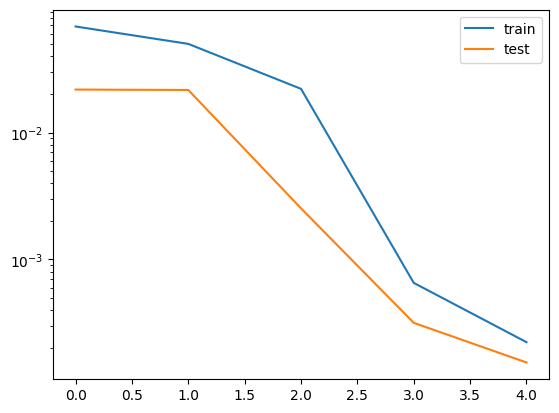

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
losses = t.Tensor(losses)
plt.plot(losses[:,0], label='train')
plt.plot(losses[:,1], label='test')
plt.legend()
plt.yscale('log')

In [58]:
for idx in range(100):
    tokens, label = test_t_dataset[idx]
    output_label = t.sigmoid(model(tokens))
    if label.item() == 1:
        print(label.item(), output_label[0,-1].item(), tokens)
    elif idx % 10 == 0:
        print(label.item(), output_label[0,-1].item())


0.0 0.00011901881225639954
0.0 0.00012145812797825783
0.0 0.00011590353824431077
0.0 0.00013035658048465848
0.0 0.00012426315515767783
0.0 0.00013444629439618438
0.0 0.0001287420600419864
0.0 0.00017955160001292825
0.0 0.0001934338069986552
0.0 0.00011936012015212327
1.0 0.9990403056144714 tensor([0, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 3, 3, 3],
       dtype=torch.int32)


# Generate Correspondence

In [62]:
from iit.utils.correspondence import Correspondence, HLNode, LLNode
from typing import Callable
from iit.utils.index import Ix




# maps elevation calculation to layer 0 attn head 0
# maps checks to layer 0 and 1 MLPs
# maps global check to layer 2 attn head 1
corr = {
    'input_hook' : [('blocks.0.hook_resid_pre', Ix[[None]], None)],
    'elevation_hook' : [('blocks.0.attn.hook_z', Ix[[None, None, 0, None]], None)],
    'elevation_check_hook' : [('blocks.0.mlp.hook_post', Ix[[None]], t.arange(0,cfg.d_model*2).int())],
    'horizon_check_hook' : [('blocks.0.mlp.hook_post', Ix[[None]], t.arange(cfg.d_model*2, cfg.d_model*4).int())], #can do this in mlp-0; separate for now.
    'balance_check_hook' : [('blocks.1.attn.hook_z', Ix[[None, None, 1, None]], None)],
}
corr_node_dict = {}
for hk, lks in corr.items():
    hn = HLNode(hk, -1)
    lns = {LLNode(name=k, index=idx, subspace=sp) for k, idx, sp in lks}
    corr_node_dict[hn] = lns

corr_obj = Correspondence(corr_node_dict)
# corr_obj = Correspondence.make_corr_from_dict(corr, suffixes={})
#set indices of heads

for k, i in corr_obj.items():
    print(f'{str(k):>20s}, {i}')

          input_hook, {LLNode(name='blocks.0.hook_resid_pre', index=[:], subspace=None)}
      elevation_hook, {LLNode(name='blocks.0.attn.hook_z', index=[:, :, 0, :], subspace=None)}
elevation_check_hook, {LLNode(name='blocks.0.mlp.hook_post', index=[:], subspace=tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63], dtype=torch.int32))}
  horizon_check_hook, {LLNode(name='blocks.0.mlp.hook_post', index=[:], subspace=tensor([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
         92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
        106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
        120, 121, 122, 123, 124,

# SIIT by hand
<details> 
  <summary> Algorithm for SIIT </summary>
  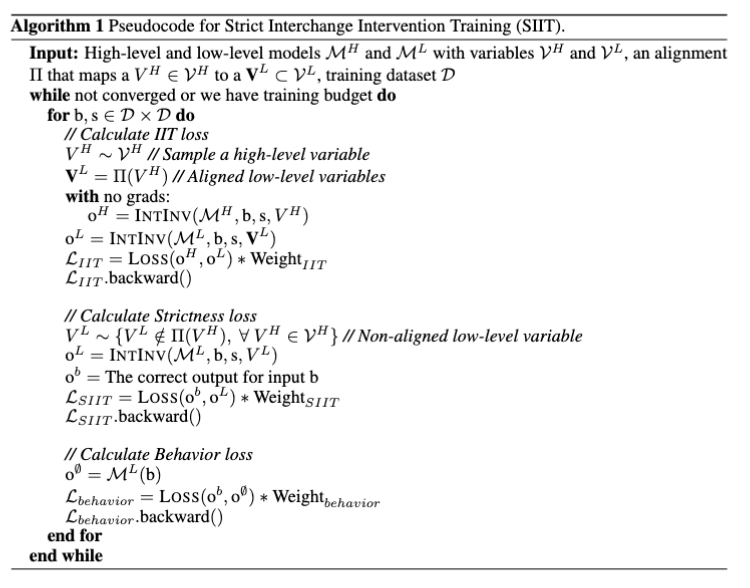
  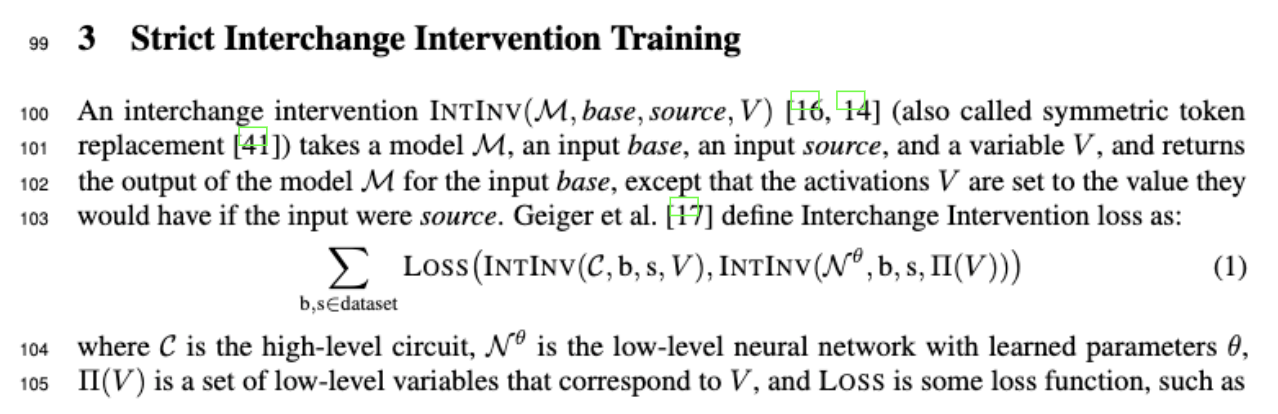
</details>

In [84]:
from functools import partial
from transformer_lens import ActivationCache

unused_model_labels = [
    ('blocks.0.attn.hook_z', [1]), 
    ('blocks.1.attn.hook_z', [0]), 
    'blocks.1.mlp.hook_post']
unused_hook_nodes = []
for label in unused_model_labels:
    if isinstance(label, tuple):
        hook, heads = label
        for head in heads:
            unused_hook_nodes.append(LLNode(name=hook, index=Ix[[None,None,head,None]]))
    else:
        unused_hook_nodes.append(LLNode(name=label, index=Ix[[None]]))
print(unused_hook_nodes)
corr_keys = list(corr_obj.keys())

hl_model = HighLevelParensBalanceChecker()
ll_model = OneLogitHookedTransformer(cfg)

def interchange_intervention(activation, hook, cache, key):
    activation = cache[key]
    # print(key, activation.shape)
    return activation

#lifted from https://github.com/cybershiptrooper/iit/blob/main/iit/model_pairs/base_model_pair.py#L148 and modified
def make_ll_ablation_hook(
    ll_node: LLNode,
    ll_cache: ActivationCache
) -> Callable[[t.Tensor, HookPoint], t.Tensor]:

    def ll_ablation_hook(hook_point_out: t.Tensor, hook: HookPoint) -> t.Tensor:
        keep_mask = t.ones_like(hook_point_out)
        index = ll_node.index if ll_node.index is not None else Ix[[None]]
        keep_mask[index.as_index] -= 1
        if ll_node.subspace is not None:
            subspace = [slice(None)]*(hook_point_out.dim()-1) + [ll_node.subspace]
            keep_mask[tuple(subspace)] -= 1
        hook_point_out = keep_mask*hook_point_out + (1-keep_mask)*ll_cache[hook.name]
        return hook_point_out
       
    return ll_ablation_hook


def loss_fn(outputs, labels):
    return t.nn.BCEWithLogitsLoss()(outputs[:,-1], labels)


iit_weight = 1
siit_weight = 1
plain_weight = 1


train_dataloader2 = DataLoader(train_t_dataset, batch_size=batch_size, shuffle = True)
test_dataloader2 = DataLoader(test_t_dataset, batch_size=batch_size, shuffle = True)
# Define the number of epochs
N = 10

# Initialize the optimizer
optimizer = t.optim.AdamW(ll_model.parameters(), lr=1e-3)

losses = []

# Training loop
for epoch in range(N):
    print(f"Epoch {epoch + 1}/{N}")
    ll_model.train()  # Set the model to training mode
    
    # Initialize tqdm progress bar for training
    train_loss = 0.0
    base_loss = 0.0
    train_progress_bar = tqdm(zip(train_dataloader, train_dataloader2), desc="Training", leave=False)
    for b, s in train_progress_bar:
        # Zero the parameter gradients
        optimizer.zero_grad()

        ##########
        #IIT loss 
        ##########       
        # sample one of the operations to do the intervention on:
        hl_key = str(corr_keys[t.randint(0, len(corr_keys), (1,)).item()])
        ll_key = corr_obj[hl_key]
    
        #run forward passes to get activations from s
        with t.no_grad():
            _, hl_cache = hl_model.run_with_cache(s[0])
            _, ll_cache = ll_model.run_with_cache(s[0])
            #run the intervention on the Hl model doing a forward pass with b
            hl_hook_fn = partial(interchange_intervention, cache=hl_cache, key=hl_key)
            hl_output = hl_model.run_with_hooks(b[0], fwd_hooks=[
                (hl_key, hl_hook_fn)
            ])
            hl_label = hl_output[:,-1].cuda()
        hooks = []
        for node in ll_key:
            # ll_hook_fn = partial(interchange_intervention, cache=ll_cache, key=node.name)
            ll_hook_fn = make_ll_ablation_hook(node, ll_cache)
            hooks.append((node.name, ll_hook_fn))
        ll_output = ll_model.run_with_hooks(b[0], fwd_hooks=hooks)
        iit_loss = loss_fn(ll_output, hl_label)

        ##########
        #SIIT loss 
        ##########
        # Sample a hook from the unused ones
        siit_node = unused_hook_nodes[t.randint(0, len(unused_hook_nodes), (1,)).item()]
        # siit_hook_fn = partial(interchange_intervention, cache=ll_cache, key=siit_key)
        #TODO: Change sampling here.
        siit_hook_fn = make_ll_ablation_hook(siit_node, ll_cache)
        siit_output = ll_model.run_with_hooks(b[0], fwd_hooks=[
            (siit_node.name, siit_hook_fn)
        ])
        siit_loss = loss_fn(siit_output, b[1].cuda())

        ####################
        # Behavior loss
        ####################
        # Get the inputs and labels from the batch
        inputs, labels = b
        outputs = ll_model(inputs)

        # Compute the loss
        plain_loss = loss_fn(outputs, labels.cuda())
        loss = plain_weight*plain_loss + iit_loss*iit_weight + siit_loss*siit_weight

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update progress bar and accumulate loss
        train_loss += loss.item()
        base_loss += plain_loss.item()
        train_progress_bar.set_postfix(loss=loss.item())

    # Evaluation phase
    ll_model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    with t.no_grad():  # No need to compute gradients during evaluation
        val_progress_bar = tqdm(test_dataloader, desc="Validation", leave=False)
        for batch in val_progress_bar:
            # Get the inputs and labels from the batch
            inputs, labels = batch

            # Forward pass
            outputs = ll_model(inputs)

            # Compute the loss
            loss = loss_fn(outputs, labels.cuda())
            total_loss += loss.item()
            val_progress_bar.set_postfix(loss=loss.item())


        # Calculate IIA.
        N_samples = 0
        iia_sum = 0
        for b, s in zip(test_dataloader, test_dataloader2):
            # sample one of the operations to do the intervention on:
            hl_key = str(corr_keys[t.randint(0, len(corr_keys), (1,)).item()])
            ll_key = corr_obj[hl_key]
            
            #run forward passes to get activations from s
            _, hl_cache = hl_model.run_with_cache(s[0])
            _, ll_cache = ll_model.run_with_cache(s[0])
            
            #run the intervention on the HL model doing a forward pass with b
            hl_hook_fn = partial(interchange_intervention, cache=hl_cache, key=hl_key)
            hl_output = hl_model.run_with_hooks(b[0], fwd_hooks=[
                (hl_key, hl_hook_fn)
            ])
            hl_label = hl_output[:,-1].cuda()
            #run the intervention on the LL model doing a forward pass with b
            hooks = []
            for node in ll_key:
                # ll_hook_fn = partial(interchange_intervention, cache=ll_cache, key=node.name)
                ll_hook_fn = make_ll_ablation_hook(node, ll_cache)
                hooks.append((node.name, ll_hook_fn))
            ll_output = ll_model.run_with_hooks(b[0], fwd_hooks=hooks)
            ll_prob = t.sigmoid(ll_output)[:,-1]

            #Calculate similarity of hl_output and ll_output.
            # This follows eqn 3 of https://arxiv.org/pdf/2112.00826
            tol = 1e-3 #floating point error tolerance really
            similarity = t.abs(hl_label - (ll_prob > 0.5).float()) < tol
            iia_sum += t.sum(similarity).item()
            N_samples += b[0].shape[0]
            
    
    avg_iia = iia_sum / N_samples
    avg_train_loss = train_loss / len(train_dataloader)
    avg_val_loss = total_loss / len(test_dataloader)
    avg_base_loss = base_loss / len(train_dataloader)
    print(f"Training loss: ({avg_base_loss:.4f}, {avg_train_loss:.4f}) | Validation loss: {avg_val_loss:.4f} | Validation IIA: {avg_iia}")
    losses.append((avg_train_loss, avg_val_loss))
print(t.Tensor(losses))
    

[LLNode(name='blocks.0.attn.hook_z', index=[:, :, 1, :], subspace=None), LLNode(name='blocks.1.attn.hook_z', index=[:, :, 0, :], subspace=None), LLNode(name='blocks.1.mlp.hook_post', index=[:], subspace=None)]
Epoch 1/10


Training loss: (0.0862, 0.2884) | Validation loss: 0.0585 | Validation IIA: 0.9755
Epoch 2/10


Training loss: (0.0130, 0.0906) | Validation loss: 0.0014 | Validation IIA: 0.9911
Epoch 3/10


Training loss: (0.0020, 0.0375) | Validation loss: 0.0006 | Validation IIA: 0.99355
Epoch 4/10


Training loss: (0.0046, 0.0346) | Validation loss: 0.0004 | Validation IIA: 0.9951
Epoch 5/10


Training loss: (0.0022, 0.0189) | Validation loss: 0.0003 | Validation IIA: 0.9984
Epoch 6/10


Training loss: (0.0024, 0.0172) | Validation loss: 0.0003 | Validation IIA: 0.99825
Epoch 7/10


Training loss: (0.0001, 0.0021) | Validation loss: 0.0002 | Validation IIA: 0.99985
Epoch 8/10


Training loss: (0.0083, 0.0372) | Validation loss: 0.0035 | Validation IIA: 0.99105
Epoch 9/10


Training loss: (0.0012, 0.0129) | Validation loss: 0.0002 | Validation IIA: 0.99945
Epoch 10/10


Training loss: (0.0001, 0.0015) | Validation loss: 0.0001 | Validation IIA: 0.9998
tensor([[2.8840e-01, 5.8533e-02],
        [9.0606e-02, 1.4121e-03],
        [3.7487e-02, 5.6503e-04],
        [3.4630e-02, 4.1524e-04],
        [1.8866e-02, 3.1447e-04],
        [1.7191e-02, 3.0641e-04],
        [2.1335e-03, 2.0772e-04],
        [3.7243e-02, 3.5148e-03],
        [1.2902e-02, 1.7547e-04],
        [1.4982e-03, 9.3030e-05]])


There seems to be some randomness in how the results of training turn out w.r.t. the cell below! Probably worth testing out different sampling methods for iit, siit, etc.

In [85]:
def make_post_ablation_hook(
    ll_node: LLNode,
    ll_cache: ActivationCache,
    method: str = "mean"
) -> Callable[[t.Tensor, HookPoint], t.Tensor]:

    def ll_ablation_hook(hook_point_out: t.Tensor, hook: HookPoint) -> t.Tensor:
        keep_mask = t.ones_like(hook_point_out)
        index = ll_node.index if ll_node.index is not None else Ix[[None]]
        keep_mask[index.as_index] -= 1
        if ll_node.subspace is not None:
            subspace = [slice(None)]*(hook_point_out.dim()-1) + [ll_node.subspace]
            keep_mask[tuple(subspace)] -= 1
        if method == "mean":
            hook_point_out = keep_mask*hook_point_out + (1-keep_mask)*t.mean(ll_cache[hook.name], dim=1, keepdim=True)
        elif method == 'zero':
            hook_point_out = keep_mask*hook_point_out
        else:
            raise ValueError(f"Unknown ablation method: {method}")
        return hook_point_out
       
    return ll_ablation_hook
    
for idx in range(100):
    tokens, label = test_t_dataset[idx]
    output_label = t.sigmoid(ll_model(tokens))
    output, cache = ll_model.run_with_cache(tokens)
    ablated_output = t.sigmoid(ll_model.run_with_hooks(tokens, fwd_hooks=[
        (node.name, make_post_ablation_hook(node, cache, method='mean')) for node in unused_hook_nodes
    ]))
    if label.item() == 1:
        print(label.item(), f'{output_label[0,-1].item():.2e}, {ablated_output[0,-1].item():.2e}', tokens)
    elif idx % 10 == 0:
        print(label.item(), f'{output_label[0,-1].item():.2e}, {ablated_output[0,-1].item():.2e}',)

0.0 2.82e-05, 4.89e-05
0.0 1.74e-05, 2.59e-05
0.0 1.80e-05, 3.33e-05
0.0 2.46e-05, 4.01e-05
0.0 2.18e-05, 1.76e-04
0.0 4.74e-05, 1.74e-04
0.0 2.20e-05, 1.92e-05
0.0 2.07e-05, 2.42e-05
0.0 2.86e-05, 4.11e-05
0.0 2.13e-05, 3.16e-05
1.0 1.00e+00, 9.91e-01 tensor([0, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 3, 3, 3],
       dtype=torch.int32)


In [86]:
from safetensors.torch import save_file
state_dict = ll_model.state_dict()
# Save the state dictionary using safetensors
save_file(state_dict, 'parens_checker.safetensors')


# SAE training and interp

In [89]:
import pickle
import torch
import os
import shutil
from transformer_lens import HookedTransformerConfig, HookedTransformer
from transformer_lens import HookedTransformer
from circuits_benchmark.transformers.hooked_tracr_transformer import HookedTracrTransformer

from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, decoders, trainers
from transformers import PreTrainedTokenizerFast

from functools import partial
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

from sae_lens import LanguageModelSAERunnerConfig, SAETrainingRunner
from sae_lens import SAEConfig, SAE, TrainingSAEConfig, TrainingSAE, ActivationsStore, CacheActivationsRunnerConfig, LanguageModelSAERunnerConfig
from sae_lens.training.sae_trainer import SAETrainer

import sae_lens
print(dir(sae_lens.training.sae_trainer))

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print("Using device:", device)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

['ActivationsStore', 'Adam', 'Any', 'FINETUNING_PARAMETERS', 'HookedRootModule', 'L1Scheduler', 'LanguageModelSAERunnerConfig', 'SAETrainer', 'TrainSAEOutput', 'TrainStepOutput', 'TrainingSAE', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__version__', '_log_feature_sparsity', '_update_sae_lens_training_version', 'cast', 'contextlib', 'dataclass', 'get_lr_scheduler', 'run_evals', 'torch', 'tqdm', 'wandb']
Using device: cuda


In [90]:
import json
from safetensors.torch import save_file
import wandb
from sae_lens.sae import SAE_CFG_PATH, SAE_WEIGHTS_PATH, SPARSITY_PATH

def save_checkpoint(
        trainer: SAETrainer,
        checkpoint_name: int | str,
        wandb_aliases: list[str] | None = None,
    ) -> str:
        """ Lightly modified from https://github.com/jbloomAus/SAELens/blob/v3.5.0/sae_lens/sae_training_runner.py#L161C5-L210C31 """

        sae = trainer.sae
        os.makedirs(trainer.cfg.checkpoint_path, exist_ok=True)
        checkpoint_path = f"{trainer.cfg.checkpoint_path}/{checkpoint_name}"

        os.makedirs(checkpoint_path, exist_ok=True)

        path = f"{checkpoint_path}"
        os.makedirs(path, exist_ok=True)

        if sae.cfg.normalize_sae_decoder:
            sae.set_decoder_norm_to_unit_norm()
        sae.save_model(path)

        # let's over write the cfg file with the trainer cfg, which is a super set of the original cfg.
        # and should not cause issues but give us more info about SAEs we trained in SAE Lens.
        config = trainer.cfg.to_dict()
        with open(f"{path}/cfg.json", "w") as f:
            json.dump(config, f)
        if trainer.cfg.log_to_wandb:
            print(f'saving {path}')
            wandb.save(path)


        log_feature_sparsities = {"sparsity": trainer.log_feature_sparsity}

        log_feature_sparsity_path = f"{path}/{SPARSITY_PATH}"
        save_file(log_feature_sparsities, log_feature_sparsity_path)

        if trainer.cfg.log_to_wandb and os.path.exists(log_feature_sparsity_path):
            model_artifact = wandb.Artifact(
                f"{sae.get_name()}",
                type="model",
                metadata=dict(trainer.cfg.__dict__),
            )

            model_artifact.add_file(f"{path}/{SAE_WEIGHTS_PATH}")
            model_artifact.add_file(f"{path}/{SAE_CFG_PATH}")

            wandb.log_artifact(model_artifact, aliases=wandb_aliases)

            sparsity_artifact = wandb.Artifact(
                f"{sae.get_name()}_log_feature_sparsity",
                type="log_feature_sparsity",
                metadata=dict(trainer.cfg.__dict__),
            )
            sparsity_artifact.add_file(log_feature_sparsity_path)
            wandb.log_artifact(sparsity_artifact)

        return checkpoint_path

In [93]:
# create tokenizer
# Define your simple vocabulary
vocab = {'BOS': 0, 'UNK': 3, '(': 1, ')': 2}

# Create a Tokenizer with a WordLevel model
tokenizer = Tokenizer(models.WordLevel(vocab=vocab, unk_token="UNK"))

# Set the normalizer, pre-tokenizer, and decoder
tokenizer.normalizer = normalizers.Sequence([normalizers.Lowercase(), normalizers.StripAccents()])
tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

# Convert to Hugging Face tokenizer
hf_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tokenizer)

# Add the special tokens to the Hugging Face tokenizer
hf_tokenizer.add_special_tokens({
    'unk_token': 'UNK',
    'bos_token': 'BOS',
    'cls_token': '[CLS]',
    'sep_token': '[SEP]',
    'pad_token': '[PAD]',
    'mask_token': '[MASK]'
})

# Test the tokenizer
encoded = hf_tokenizer.encode("BOS ( )")
decoded = hf_tokenizer.decode(encoded)
print(f"Encoded: {encoded}")
print(f"Decoded: {decoded}")

Encoded: [0, 1, 2]
Decoded: BOS ( )


In [94]:
class RepeatActivationsStore(ActivationsStore):

    def get_batch_tokens(self, batch_size: int | None = None):
        """
        Streams a batch of tokens from a dataset.
        """
        if not batch_size:
            batch_size = self.store_batch_size_prompts
        sequences = []
        # the sequences iterator yields fully formed tokens of size context_size, so we just need to cat these into a batch
        for _ in range(batch_size):
            try:
                sequences.append(next(self.iterable_sequences))
            except StopIteration:
                #shuffle self.dataset and restart
                self.iterable_sequences = self._iterate_tokenized_sequences()
                sequences.append(next(self.iterable_sequences))
                # self.iterable_dataset = iter(self.dataset)
                # s = next(self.iterable_dataset)[self.tokens_column]
            
        return torch.stack(sequences, dim=0).to(self.model.W_E.device)
    
    def _get_next_dataset_tokens(self) -> torch.Tensor:
        device = self.device
        if not self.is_dataset_tokenized:
            try:
                s = next(self.iterable_dataset)[self.tokens_column]
            except StopIteration:
                #shuffle self.dataset and restart
                self.iterable_dataset = iter(self.dataset)
                s = next(self.iterable_dataset)[self.tokens_column]
            tokens = (
                self.model.to_tokens(
                    s,
                    truncate=False,
                    move_to_device=True,
                    prepend_bos=self.prepend_bos,
                )
                .squeeze(0)
                .to(device)
            )
            assert (
                len(tokens.shape) == 1
            ), f"tokens.shape should be 1D but was {tokens.shape}"
        else:
            try:
                s = next(self.iterable_dataset)[self.tokens_column]
            except StopIteration:
                #shuffle self.dataset and restart
                self.iterable_dataset = iter(self.dataset)
                s = next(self.iterable_dataset)[self.tokens_column]
            tokens = torch.tensor(
                s,
                dtype=torch.long,
                device=device,
                requires_grad=False,
            )
            if (
                not self.prepend_bos
                and tokens[0] == self.model.tokenizer.bos_token_id  # type: ignore
            ):
                tokens = tokens[1:]
        self.n_dataset_processed += 1
        return tokens

In [99]:

def make_sae_lens_config(hook_name: str, hook_layer: int, l1_coeff: float, training_tokens: int = 1_500_000, hook_head_index : int = None):
    return LanguageModelSAERunnerConfig(
        # Data Generating Function (Model + Training Distribution)
        model_name = "parens-test",
        model_class_name = "HookedTransformer",
        hook_name = hook_name,
        hook_eval = "NOT_IN_USE",
        hook_layer = hook_layer,
        hook_head_index = hook_head_index,
        dataset_path = "",
        dataset_trust_remote_code = False,
        streaming = False,
        is_dataset_tokenized = True,
        context_size = ll_model.cfg.n_ctx,
        use_cached_activations = False,
        cached_activations_path = None,  # Defaults to "activations/{dataset}/{model}/{full_hook_name}_{hook_head_index}"
    
        # SAE Parameters
        d_in = ll_model.cfg.d_head,
        d_sae = None,
        b_dec_init_method = "geometric_median",
        expansion_factor = 4,
        activation_fn = "relu",  # relu, tanh-relu
        normalize_sae_decoder = True,
        noise_scale = 0.0,
        from_pretrained_path = None,
        apply_b_dec_to_input = False,
        decoder_orthogonal_init = False,
        decoder_heuristic_init = False,
        init_encoder_as_decoder_transpose = False,
    
        # Activation Store Parameters
        training_tokens = training_tokens,
        finetuning_tokens = 0,
        store_batch_size_prompts = 4,
        normalize_activations = "none",  # none, expected_average_only_in (Anthropic April Update), constant_norm_rescale (Anthropic Feb Update)
    
        # Misc
        device = device,
        act_store_device = "with_model",  # will be set by post init if with_model
        seed = 42,
        dtype = "float32",  # type: ignore #
        prepend_bos = False,
    
        # Performance - see compilation section of lm_runner.py for info
        autocast = False,  # autocast to autocast_dtype during training
        autocast_lm = False,  # autocast lm during activation fetching
        compile_llm = False,  # use torch.compile on the LLM
        llm_compilation_mode = None,  # which torch.compile mode to use
        compile_sae = False,  # use torch.compile on the SAE
        sae_compilation_mode = None,
    
        # Training Parameters
    
        ## Batch size
        train_batch_size_tokens = 320//4,
    
        ## Adam
        adam_beta1 = 0.9,
        adam_beta2 = 0.999,
    
        ## Loss Function
        mse_loss_normalization = None,
        l1_coefficient = l1_coeff,
        lp_norm = 1,
        scale_sparsity_penalty_by_decoder_norm = False,
        l1_warm_up_steps = 0,
    
        ## Learning Rate Schedule
        lr = 3e-4,
        lr_scheduler_name = "constant",  # constant, cosineannealing, cosineannealingwarmrestarts
        lr_warm_up_steps = 0,
        lr_end = None,  # only used for cosine annealing, default is lr / 10
        lr_decay_steps = 0,
        n_restart_cycles = 1,  # used only for cosineannealingwarmrestarts
    
        ## FineTuning
        finetuning_method = None,  # scale, decoder or unrotated_decoder
    
        # Resampling protocol args
        use_ghost_grads = True,  # want to change this to true on some timeline.
        feature_sampling_window = 2000,
        dead_feature_window = 1000,  # unless this window is larger feature sampling,
        dead_feature_threshold = 1e-8,
    
        # Evals
        n_eval_batches = 10,
        eval_batch_size_prompts = None,  # useful if evals cause OOM
    
        # WANDB
        log_to_wandb = True,
        log_activations_store_to_wandb = False,
        log_optimizer_state_to_wandb = False,
        wandb_project = "benchmark_saes",
        wandb_id = None,
        run_name = None,
        wandb_entity = None,
        wandb_log_frequency = 10,
        eval_every_n_wandb_logs = 100000000000, # Make this a really big number; currently fails because it tries to compute CE loss.
        # Misc
        resume = False,
        n_checkpoints = 5,
        checkpoint_path = f"$HOME/persistent-storage/tracr_saes/parens-test",
        verbose = True,
        model_kwargs = dict(),
        model_from_pretrained_kwargs = dict(),
        sae_lens_version = str(sae_lens.__version__),
        sae_lens_training_version = str(sae_lens.__version__),
    )

runner_cfg = make_sae_lens_config("blocks.0.attn.hook_z", 0, hook_head_index=0, l1_coeff=1e-1, training_tokens=1_500_000)

Run name: 64-L1-0.1-LR-0.0003-Tokens-1.500e+06
n_tokens_per_buffer (millions): 0.0016
Lower bound: n_contexts_per_buffer (millions): 8e-05
Total training steps: 18750
Total wandb updates: 1875
n_tokens_per_feature_sampling_window (millions): 3.2
n_tokens_per_dead_feature_window (millions): 1.6
We will reset the sparsity calculation 9 times.
Number tokens in sparsity calculation window: 1.60e+05
Using Ghost Grads.


In [ ]:
model.tokenizer = hf_tokenizer
store = RepeatActivationsStore.from_config(ll_model, runner_cfg, dataset=dataset)
sae = TrainingSAE(runner_cfg)
trainer = SAETrainer(model, sae, store, save_checkpoint, cfg = runner_cfg)

if runner_cfg.log_to_wandb:
    wandb.init(
        project=runner_cfg.wandb_project,
        config=runner_cfg,
        name=runner_cfg.run_name,
        id=runner_cfg.wandb_id,
    )
trainer.fit()

wandb.finish()


Training SAE:   0%|                                                                           | 0/1500000 [00:00<?, ?it/s]/opt/venv/lib/python3.10/site-packages/sae_lens/training/activations_store.py:254: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yield torch.tensor(

100| MSE Loss 2.406 | L1 0.565:   0%|                                                         | 0/1500000 [00:00<?, ?it/s]
100| MSE Loss 2.406 | L1 0.565:   1%|▏                                           | 8000/1500000 [00:00<02:52, 8651.67it/s]
200| MSE Loss 0.451 | L1 0.544:   1%|▏                                           | 8000/1500000 [00:01<02:52, 8651.67it/s]
200| MSE Loss 0.451 | L1 0.544:   1%|▍                                          | 16000/1500000 [00:01<02:48, 8796.44it/s]
300| MSE Loss 0.176 | L1 0.536:   1%|▍                                          | 1

saving $HOME/persistent-storage/tracr_saes/parens-test/9y5ai1nk/300080



3800| MSE Loss 0.029 | L1 0.249:  20%|████████                                 | 296000/1500000 [00:34<02:15, 8910.67it/s]
3800| MSE Loss 0.029 | L1 0.249:  20%|████████▎                                | 304000/1500000 [00:34<02:37, 7598.58it/s]
3900| MSE Loss 0.027 | L1 0.211:  20%|████████▎                                | 304000/1500000 [00:35<02:37, 7598.58it/s]
3900| MSE Loss 0.027 | L1 0.211:  21%|████████▌                                | 312000/1500000 [00:35<02:32, 7806.56it/s]
4000| MSE Loss 0.028 | L1 0.229:  21%|████████▌                                | 312000/1500000 [00:36<02:32, 7806.56it/s]
4000| MSE Loss 0.028 | L1 0.229:  21%|████████▋                                | 320000/1500000 [00:36<02:27, 8026.84it/s]
4100| MSE Loss 0.033 | L1 0.411:  21%|████████▋                                | 320000/1500000 [00:37<02:27, 8026.84it/s]
4100| MSE Loss 0.033 | L1 0.411:  22%|████████▉                                | 328000/1500000 [00:37<02:22, 8208.83it/s]
4200| MSE Loss 

saving $HOME/persistent-storage/tracr_saes/parens-test/9y5ai1nk/600080



7600| MSE Loss 0.019 | L1 0.199:  40%|████████████████▍                        | 600000/1500000 [01:09<01:42, 8776.52it/s]
7600| MSE Loss 0.019 | L1 0.199:  41%|████████████████▌                        | 608000/1500000 [01:09<01:55, 7709.98it/s]
7700| MSE Loss 0.025 | L1 0.185:  41%|████████████████▌                        | 608000/1500000 [01:10<01:55, 7709.98it/s]
7700| MSE Loss 0.025 | L1 0.185:  41%|████████████████▊                        | 616000/1500000 [01:10<01:49, 8071.36it/s]
7800| MSE Loss 0.019 | L1 0.243:  41%|████████████████▊                        | 616000/1500000 [01:11<01:49, 8071.36it/s]
7800| MSE Loss 0.019 | L1 0.243:  42%|█████████████████                        | 624000/1500000 [01:11<01:46, 8239.37it/s]
7900| MSE Loss 0.021 | L1 0.221:  42%|█████████████████                        | 624000/1500000 [01:12<01:46, 8239.37it/s]
7900| MSE Loss 0.021 | L1 0.221:  42%|█████████████████▎                       | 632000/1500000 [01:12<01:42, 8508.88it/s]
8000| MSE Loss 

# Training a model with SIIT repo. 
(Largely abandoned for the work above!)

In [128]:
from transformer_lens.HookedTransformerConfig import HookedTransformerConfig
from transformer_lens.HookedTransformer import HookedTransformer
from iit.model_pairs.strict_iit_model_pair import StrictIITModelPair
from iit.utils.iit_dataset import train_test_split, IITDataset
from iit.utils.index import Ix
from tqdm.notebook import tqdm
import random
from iit.model_pairs.base_model_pair import Callable, Tensor

class OneLogitHookedTransformer(HookedTransformer):
    def forward(self, *args, **kwargs):
        output = super().forward(*args, **kwargs)
        return output[:,:,-1]

class MyStrictIITModelPair(StrictIITModelPair):
    def loss_fn(self, ll_output, hl_output):
        # print('loss shapes', ll_output.shape, hl_output.shape)
        return t.nn.BCEWithLogitsLoss()(ll_output, hl_output)

    def get_label_idxs(self):
        return Ix[[None,-1]]

    def get_behaviour_loss_over_batch(self, base_input, loss_fn):
        base_x, base_y = base_input#[0:2]
        
        label_idx = self.get_label_idxs()
        output = self.ll_model(base_x)
        behavior_loss = loss_fn(output[label_idx.as_index], base_y[label_idx.as_index])
        return behavior_loss

In [ ]:

def train_model(
    use_wandb=False,
    seed=42
):
    t.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    training_args = {
        # generic training args
        "lr": 1e-3,
        "batch_size": 256,
        "atol": 0.05,
        "clip_grad_norm": 0.1,
        "lr_scheduler": None, # or t.optim.lr_scheduler.ReduceLROnPlateau
        "early_stop": True,
        # specific iit training args
        "behavior_weight": 1,
        "iit_weight": 1,
        "strict_weight": 0.4,
        "use_single_loss": True,
        "num_workers" : 0, #TODO check value
    }

    ll_cfg = HookedTransformerConfig(
        n_layers = 3,
        d_model = 32,
        n_ctx = 20,
        d_head = 16,
        d_vocab = 4,
        act_fn = "relu",
    )
    ll_model = OneLogitHookedTransformer(ll_cfg)
    hl_model = HighLevelParensBalanceChecker()

    corr = {
    'input_hook' : ['blocks.0.hook_resid_pre'],
    'elevation_hook' : ['blocks.0.attn.hook_z'],
    'elevation_check_hook' : ['blocks.0.mlp.hook_post'],
    'horizon_check_hook' : ['blocks.1.mlp.hook_post'], #can do this in mlp-0; separate for now.
    'balance_check_hook' : ['blocks.2.attn.hook_z'],
    }
    hl_ll_corr = Correspondence.make_corr_from_dict(corr, suffixes={"attn": "attn.hook_result", "mlp": "mlp.hook_post"})

    model_pair = MyStrictIITModelPair(
        training_args=training_args,
        ll_model=ll_model,
        hl_model=hl_model,
        corr=hl_ll_corr,
    )

    # prepare iit datasets for training and testing
    dataset = generate_dataset(N_samples = 100_000, n_ctx = ll_cfg.n_ctx)
    train_dataset, test_dataset = train_test_split(
        dataset, test_size=0.2, random_state=42
    )
    train_dataset = IITDataset(train_dataset, train_dataset, seed=seed)
    test_dataset = IITDataset(test_dataset, test_dataset, seed=seed)

    # copy+paste from iit/model_pairs/base_model_pair.py
    ##The code below is basically: https://github.com/cybershiptrooper/iit/blob/main/iit/model_pairs/base_model_pair.py#L205
    training_args = training_args
    print(f"{training_args=}")
    train_loader, test_loader = model_pair.make_loaders(
            train_dataset,
            test_dataset,
            training_args["batch_size"],
            training_args["num_workers"],
    )

    early_stop = training_args["early_stop"]
    epochs = 100

    optimizer = t.optim.Adam(model_pair.ll_model.parameters(), lr=training_args["lr"])
    loss_fn = model_pair.loss_fn
    scheduler_cls = training_args.get("lr_scheduler", None)
    if scheduler_cls == t.optim.lr_scheduler.ReduceLROnPlateau:
        mode = training_args.get("scheduler_mode", "max")
        lr_scheduler = scheduler_cls(optimizer, mode=mode, factor=0.1, patience=10)
    elif scheduler_cls:
        lr_scheduler = scheduler_cls(optimizer)

    if use_wandb and not wandb.run:
        wandb.init(project="iit", name=wandb_name_suffix, 
                   entity=WANDB_ENTITY)

    if use_wandb:
        wandb.config.update(training_args)
        wandb.config.update({"method": model_pair.wandb_method})
        wandb.run.log_code()

    print('datasets', dataset.inputs, dataset.targets)
    
    for epoch in tqdm(range(epochs)):
        # train_metrics = run_train_epoch(model_pair, train_loader, loss_fn, optimizer)
        train_metrics = model_pair._run_train_epoch(train_loader, loss_fn, optimizer)
        test_metrics = model_pair._run_eval_epoch(test_loader, loss_fn)
        if scheduler_cls:
            model_pair.step_scheduler(lr_scheduler, test_metrics)
        model_pair.test_metrics = test_metrics
        model_pair.train_metrics = train_metrics
        model_pair._print_and_log_metrics(
            epoch, train_metrics.metrics + test_metrics.metrics, use_wandb
        )

        if early_stop and model_pair._check_early_stop_condition(test_metrics.metrics):
            break

    if use_wandb:
        wandb.log({"final epoch": epoch})

    print("Done training")

    return model_pair

print(train_model())

{'input_hook': HookPoint(), 'elevation_hook': HookPoint(), 'elevation_check_hook': HookPoint(), 'horizon_check_hook': HookPoint(), 'balance_check_hook': HookPoint()}
dict_keys([input_hook, elevation_hook, elevation_check_hook, horizon_check_hook, balance_check_hook])
training_args={'lr': 0.001, 'batch_size': 256, 'atol': 0.05, 'clip_grad_norm': 0.1, 'lr_scheduler': None, 'early_stop': True, 'behavior_weight': 1, 'iit_weight': 1, 'strict_weight': 0.4, 'use_single_loss': True, 'num_workers': 0}
datasets tensor([[0, 1, 3,  ..., 3, 3, 3],
        [0, 2, 3,  ..., 3, 3, 3],
        [0, 1, 1,  ..., 3, 3, 3],
        ...,
        [0, 2, 1,  ..., 3, 3, 3],
        [0, 2, 1,  ..., 3, 3, 3],
        [0, 2, 1,  ..., 3, 3, 3]], device='cuda:0') tensor([[1., 1., 1.,  ..., 1., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]], devi


100%|███████████████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 11.04it/s]



Epoch 0: train/iit_loss: 0.0726, train/behavior_loss: 0.0399, train/strict_loss: 0.0175, val/iit_loss: 0.0314, val/IIA: 0.16%, val/accuracy: 0.21%, val/strict_accuracy: 0.02%, 



100%|███████████████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.18it/s]



Epoch 1: train/iit_loss: 0.0291, train/behavior_loss: 0.0079, train/strict_loss: 0.0034, val/iit_loss: 0.0057, val/IIA: 0.00%, val/accuracy: 0.24%, val/strict_accuracy: 0.00%, 



100%|███████████████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 11.03it/s]



Epoch 2: train/iit_loss: 0.0176, train/behavior_loss: 0.0040, train/strict_loss: 0.0017, val/iit_loss: 0.0108, val/IIA: 0.05%, val/accuracy: 0.03%, val/strict_accuracy: 0.00%, 



100%|███████████████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.21it/s]



Epoch 3: train/iit_loss: 0.0091, train/behavior_loss: 0.0021, train/strict_loss: 0.0009, val/iit_loss: 0.0041, val/IIA: 0.01%, val/accuracy: 0.00%, val/strict_accuracy: 0.00%, 



100%|███████████████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 10.99it/s]



Epoch 4: train/iit_loss: 0.0038, train/behavior_loss: 0.0014, train/strict_loss: 0.0005, val/iit_loss: 0.0058, val/IIA: 0.00%, val/accuracy: 0.00%, val/strict_accuracy: 0.00%, 



100%|███████████████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 11.11it/s]



Epoch 5: train/iit_loss: 0.0113, train/behavior_loss: 0.0019, train/strict_loss: 0.0008, val/iit_loss: 0.0036, val/IIA: 0.00%, val/accuracy: 0.05%, val/strict_accuracy: 0.00%, 



100%|███████████████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 11.10it/s]



Epoch 6: train/iit_loss: 0.0067, train/behavior_loss: 0.0020, train/strict_loss: 0.0008, val/iit_loss: 0.0008, val/IIA: 0.00%, val/accuracy: 0.00%, val/strict_accuracy: 0.00%, 



100%|███████████████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 10.88it/s]



Epoch 7: train/iit_loss: 0.0068, train/behavior_loss: 0.0021, train/strict_loss: 0.0008, val/iit_loss: 0.0061, val/IIA: 0.00%, val/accuracy: 0.00%, val/strict_accuracy: 0.00%, 



100%|███████████████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.28it/s]



Epoch 8: train/iit_loss: 0.0044, train/behavior_loss: 0.0008, train/strict_loss: 0.0003, val/iit_loss: 0.0010, val/IIA: 0.00%, val/accuracy: 0.00%, val/strict_accuracy: 0.00%, 



100%|███████████████████████████████████████████████████████████████████████████████████| 313/313 [00:27<00:00, 11.25it/s]



Epoch 9: train/iit_loss: 0.0051, train/behavior_loss: 0.0009, train/strict_loss: 0.0003, val/iit_loss: 0.0020, val/IIA: 0.00%, val/accuracy: 0.00%, val/strict_accuracy: 0.00%, 



100%|███████████████████████████████████████████████████████████████████████████████████| 313/313 [00:28<00:00, 10.91it/s]